
<img align="left" src="https://earthdata.nasa.gov/img/earthdata-fb-image.jpg" width="250">

## __Ocean salinity investigation:__

### __Hands-on tutorial of AWS in-region access of NASA Earthdata products__


This notebook provides a basic end-to-end workflow to interact with data "in-place" from the NASA Earthdata Cloud, by accessing AWS s3 locations provided by [NASA Harmony](http://harmony.earthdata.nasa.gov/) outputs without the need to download data. While these outputs can be downloaded locally, the cloud offers the ability to scale compute resources to perform analyses over large areas and time spans, which is critical as data volumes continue to grow. 

This workflow combines search, discovery, access, reformatting, basic analyses, and plotting components presented during Part-II. Though the example we're working with in this notebook only focuses on a small time and area to account for a large number of concurrent processing requests, this workflow can be modified and scaled up to suit a larger time range and region of interest. 

#### Learning objectives:

- Understand the Pangeo BinderHub environment used during the workshop and how to execute code within a Jupyter Notebook
- Execute programmatic data access queries, plotting, and direct in-region cloud access using open source Python libraries.
- Identify where and when Earthdata Cloud components are implemented across data discovery, subsetting, access, and analysis/compute workflows.
- Develop new strategies for leveraging and integrating Earthdata Cloud capabilities within your own work.
- Identify resources, including the Earthdata Cloud Primer, for getting started with Amazon Web Services outside of the Workshop to access and work with data with a cloud environment.


___

<p float="left">
    <img src="https://jupyter.org/assets/main-logo.svg" width="100">
    <img src="https://github.com/pangeo-data/pangeo/raw/master/docs/_static/pangeo_simple_logo.svg" width="200">
    
</p>




### __Pangeo BinderHub and Project Jupyter__

First, some basics on the Pangeo compute environment used during the live workshop and how to interact with Jupyter Notebooks and the Jupyter Lab interface.

* [Pangeo BinderHub](https://binder.pangeo.io/): A multi-user server for interactive data analysis. This Hub is running in the AWS `us-west-2` region, which is where all Earthdata Cloud data and transformation service outputs are located. Pangeo is supported, in part, by the National Science Foundation (NSF) and the National Aeronautics and Space Administration (NASA). Google provided compute credits on Google Compute Engine. The Pangeo community promotes open, reproducible, and scalable science. We thank you for supporting this AGU Workshop.

**This Hub is only supported during the live AGU workshop**. See instructions at the bottom of this notebook for how to set up your own AWS EC2 instance so that you can perform the same cloud access within your personal AWS environment. 

* [Jupyter Notebook](https://jupyter-notebook.readthedocs.io/en/latest/): Interactive, reproducible, open source, and exploratory browser integrated computing environment.
* [JupyterLab](https://github.com/jupyterlab/jupyterlab): Web-based integrated IDE for computational workflows.

### __Jupyter Notebook Basics__

The body of a notebook is composed of cells. Each cell contains either markdown, code input, code output, or raw text. Cells can be included in any order and edited and executed at-will.

**Markdown cells** - These are used to build a nicely formatted narrative around the code in the document.

**Code cells** - These are used to define the computational code in the document. They come in two forms: the input cell where the user types the code to be executed, and the output cell which is the representation of the executed code.

**Raw cells** - These are used when text needs to be included in raw form, without execution or transformation.

#### Execute a cell or selected cells by pressing shift + enter


In [ ]:
print('Hello World!')

#### Collapse a cell or cell output by clicking on the blue line to the left of the cell

The cell content is replaced by three dots, indicating that the cell is collapsed.

#### Execute multiple cells or run the entire notebook
Select cells with **shift + Up** or **shift + Down** and then execute selection with **shift + enter**.

#### Run the whole notebook in a single step by clicking on the menu Run -> Run All Cells.

See https://jupyter.readthedocs.io/en/latest/running.html for more guidance on running notebooks.

___
### __Import modules__

The Python ecosystem is organized into modules.  A module must be imported before the contents of that modules can be used.  It is good practice to import modules in the first code cell of a notebook or at the top of your script.  Not only does this make it clear which modules are being used, but it also ensures that the code fails at the beginning because one of the modules is not installed rather half way through after crunching a load of data.

For some modules, it is common practice to shorten the module names according to accepted conventions.  For example, the plotting module `matplotlib.pyplot` is shortened to `plt`.  It is best to stick to these conventions rather than making up your own short names so that people reading your code see immediately what you are doing. 

In [6]:
#import tutorial_helper_functions as fn
from netrc import netrc
from platform import system
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser
from pprint import pprint
import intake
import s3fs
import rasterio
import zarr
import matplotlib.pyplot as plt

import time
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy
import zarr
import s3fs
from IPython.display import HTML
import json


%matplotlib inline

## __Earthdata Login__

Authentication info...

In [ ]:
# # Get your authentication token for searching restricted records in the CMR:
# _token = fn.setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# # Start authenticated session with URS to allow restricted data downloads:
# fn.setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

In [2]:
TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username:  amy.steiker
Password:  ·········


## __CMR Search/Discovery__


In [12]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-52,-2,-43,6'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
#temporal = '2019-01-01T00:00:00Z,2019-12-31T23:59:59Z'
#temporal = '2019-02-01T00:00:00Z,2019-08-31T23:59:59Z'
temporal = '2019-04-01T00:00:00Z,2019-04-30T23:59:59Z'

In [13]:
search_parameters = { 
    'grace': {
        'short_name': 'TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2',
        'provider': 'POCLOUD',
        'bounding_box': bounding_box,
        'temporal': temporal,
        'token': _token},
    'smap': {
        'short_name': 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V4',
        'provider': 'POCLOUD',
        'bounding_box': bounding_box,
        'temporal': temporal,
        'token': _token},
            }

#### Discover file number and file size 

Using CMR search, determine the number of files that exist over this time and area of interest, as well as the average size and total volume of those files.

In [14]:
search_url = "https://cmr.earthdata.nasa.gov/search/granules"
output_format="json"

for k, v in search_parameters.items(): #fn.search_granules(search_parameters[k], _token)
    parameters = {
        "scroll": "true",
        "page_size": 100,
    }

    response = requests.post(f"{search_url}.{output_format}", params=parameters, data=v)
    response.raise_for_status()

    hits = int(response.headers['CMR-Hits'])
    if hits > 0:
        print(f"Found {hits} files")
        results = json.loads(response.content)
        granules = []
        granules.extend(results['feed']['entry'])
        granule_sizes = [float(granule['granule_size']) for granule in granules]
        print(f"The total size of all files is {sum(granule_sizes):.2f} MB")
    else:
        print("Found no hits")

Found 1 files
The total size of all files is 747.55 MB
Found 38 files
The total size of all files is 221.45 MB


Discover data access URLs...

In [17]:
r = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.umm_json", 
                 params=search_parameters['grace'])
grace_gran = r.json()
print("files returned:",grace_gran['hits'])
grace_gran['items'][0]['umm']['RelatedUrls']

files returned: 1


[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.cmr.json',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc',
  'Type': 'GET DATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc.md5',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'}]

In [18]:
grace_url = grace_gran['items'][0]['umm']['RelatedUrls'][1]['URL']
grace_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc'

In [22]:
r = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.umm_json", 
                 params=search_parameters['smap'])

smap_gran = r.json()
print("files returned:",smap_gran['hits'])
smap_gran['items'][0]['umm']['RelatedUrls']

files returned: 38


[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V4/RSS_smap_SSS_L3_8day_running_2019_087_FNL_v04.0.nc.md5',
  'Description': 'Download RSS_smap_SSS_L3_8day_running_2019_087_FNL_v04.0.nc.md5',
  'Type': 'EXTENDED METADATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V4/RSS_smap_SSS_L3_8day_running_2019_087_FNL_v04.0.nc',
  'Description': 'Download RSS_smap_SSS_L3_8day_running_2019_087_FNL_v04.0.nc',
  'Type': 'GET DATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V4/RSS_smap_SSS_L3_8day_running_2019_087_FNL_v04.0.cmr.json',
  'Description': 'Download RSS_smap_SSS_L3_8day_running_2019_087_FNL_v04.0.cmr.json',
  'Type': 'EXTENDED METADATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/s3credentials',
  'Description': 'api endpoint to retrieve temporary credentials vali

Then, to do a regular HTTPS download:
    
```python
r = requests.get(grace_url)
with open('tutorial7_data_GRACEFO.nc', 'wb') as f:
    f.write(r.content)

!ncdump -h tutorial7_data_GRACEFO.nc
```

But we'll use the Harmony API's Zarr Reformatter service instead of downloading the entire granule. The zarr format will allow us to open and download/read just the data that we require for our Amazon Basin study area.

#### __Before we access, some background on our different AWS access methods...__

- Harmony: Need access keys
- CMR direct access: (maybe not showing this in this notebook),
- MUR data in AWS OpenRegistry

## __Harmony Access__

More info on Harmony, Zarr, etc.

Find collection ID:

In [23]:
r = requests.get(url="https://cmr.earthdata.nasa.gov/search/collections.umm_json", 
                 params=search_parameters['grace'])

grace_coll = r.json()
grace_coll['hits']
grace_coll_meta = grace_coll['items'][0]['meta']
grace_coll_id = grace_coll_meta['concept-id']
print(grace_coll_id)

r = requests.get(url="https://cmr.earthdata.nasa.gov/search/collections.umm_json", 
                 params=search_parameters['smap'])

smap_coll = r.json()
smap_coll['hits']

smap_coll_meta = smap_coll['items'][0]['meta']
smap_coll_id = smap_coll_meta['concept-id']
print(smap_coll_id)

C1938032626-POCLOUD
C1940468263-POCLOUD


In [ ]:
# lat_list = ((search_parameters['bounding_box'].split(","))[1],":",(search_parameters['bounding_box'].split(","))[3])
# search_parameters['lat'] = "(" + ''.join(lat_list) + ")"
# lon_list = ((search_parameters['bounding_box'].split(","))[0],":",(search_parameters['bounding_box'].split(","))[2])
# search_parameters['lon'] = "(" + ''.join(lon_list) + ")"
# t1 = search_parameters['temporal'].split(',')[0]
# t2 = search_parameters['temporal'].split(',')[1]
# search_parameters['time'] = f'("{t1}":"{t2}")'

#### SMAP request:

In [24]:
harmony_root = 'https://harmony.earthdata.nasa.gov'
harmony_params = {
    'collection_id': smap_coll_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'lat':'(-2:6)',
    'lon':'(-52:43)',
    'start': '2019-04-01T00:00:00Z',
    'stop':'2019-04-30T23:59:59Z',
    'format': 'application/x-zarr',
}

smap_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?format={format}&subset=lat{lat}&subset=lon{lon}&subset=time("{start}":"{stop}")'.format(**harmony_params)
print(smap_url)

https://harmony.earthdata.nasa.gov/C1940468263-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr&subset=lat(-2:6)&subset=lon(-52:43)&subset=time("2019-04-01T00:00:00Z":"2019-04-30T23:59:59Z")


In [25]:
smap_response = request.urlopen(smap_url)
smap_results = smap_response.read()
smap_json = loads(smap_results)
print(dumps(smap_json, indent=2))
smap_jobId = smap_json['jobID']

{
  "username": "amy.steiker",
  "status": "running",
  "message": "Data in output files may extend outside the spatial bounds you requested.",
  "progress": 0,
  "createdAt": "2020-12-03T03:13:58.509Z",
  "updatedAt": "2020-12-03T03:13:58.509Z",
  "links": [
    {
      "title": "Job Status",
      "href": "https://harmony.earthdata.nasa.gov/jobs/70985f58-3966-439a-807b-a36995228838",
      "rel": "self",
      "type": "application/json"
    }
  ],
  "request": "https://harmony.earthdata.nasa.gov/C1940468263-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application%2Fx-zarr&subset=lat(-2%3A6)&subset=lon(-52%3A43)&subset=time(%222019-04-01T00%3A00%3A00Z%22%3A%222019-04-30T23%3A59%3A59Z%22)",
  "jobID": "70985f58-3966-439a-807b-a36995228838"
}


In [35]:
smap_job_url = f'https://harmony.earthdata.nasa.gov/jobs/{jobId}'

while True:
    loop_response = request.urlopen(smap_job_url)
    loop_results = loop_response.read()
    job_json = loads(loop_results)
    if job_json['status'] != 'running':
        break
    print(f"# Job status is running. Progress is {job_json['progress']} %. Trying again.")
    time.sleep(10)

smap_links = []
if job_json['status'] == 'successful' and job_json['progress'] == 100:
    print("# Job progress is 100%. Links to job outputs are displayed below:")
    smap_links = [link['href'] for link in job_json['links']]
    display(smap_links)

# Job progress is 100%. Links to job outputs are displayed below:


['https://harmony.earthdata.nasa.gov/jobs/70985f58-3966-439a-807b-a36995228838',
 'https://harmony.earthdata.nasa.gov/stac/70985f58-3966-439a-807b-a36995228838/',
 'https://harmony.earthdata.nasa.gov/cloud-access.sh',
 'https://harmony.earthdata.nasa.gov/cloud-access',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/4a37bda6-9b22-412b-b7e3-e7e1d096a466/',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/4a37bda6-9b22-412b-b7e3-e7e1d096a466/RSS_smap_SSS_L3_8day_running_2019_087_FNL_v04.0.zarr',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/4a37bda6-9b22-412b-b7e3-e7e1d096a466/RSS_smap_SSS_L3_8day_running_2019_088_FNL_v04.0.zarr',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/4a37bda6-9b22-412b-b7e3-e7e1d096a466/RSS_smap_SSS_L3_8day_running_2019_089_FNL_v04.0.zarr',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/4a37bda6-9b22-412b-b7e3-e7e1d096a466/RSS_smap_SSS_L3_8day_running_2019_090_FNL_v04.0.zarr',
 's3://harmony-prod-staging/publ

#### GRACE request:

In [30]:
harmony_root = 'https://harmony.earthdata.nasa.gov'
harmony_params = {
    'collection_id': grace_coll_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'lat':'(-2:6)',
    'lon':'(-52:43)',
    'start': '2019-04-01T00:00:00Z',
    'stop':'2019-04-30T23:59:59Z',
    'format': 'application/x-zarr',
}

grace_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?format={format}&subset=lat{lat}&subset=lon{lon}&subset=time("{start}":"{stop}")'.format(**harmony_params)
print(grace_url)

https://harmony.earthdata.nasa.gov/C1938032626-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr&subset=lat(-2:6)&subset=lon(-52:43)&subset=time("2019-04-01T00:00:00Z":"2019-04-30T23:59:59Z")


In [49]:
grace_response = request.urlopen(grace_url)
grace_results = grace_response.read()
grace_json = loads(grace_results)
print(dumps(grace_json, indent=2))
grace_jobId = grace_json['jobID']

{
  "username": "amy.steiker",
  "status": "running",
  "message": "Data in output files may extend outside the spatial bounds you requested.",
  "progress": 0,
  "createdAt": "2020-12-03T03:56:55.542Z",
  "updatedAt": "2020-12-03T03:56:55.542Z",
  "links": [
    {
      "title": "Job Status",
      "href": "https://harmony.earthdata.nasa.gov/jobs/6580b087-c476-491d-a09f-43f76020157a",
      "rel": "self",
      "type": "application/json"
    }
  ],
  "request": "https://harmony.earthdata.nasa.gov/C1938032626-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application%2Fx-zarr&subset=lat(-2%3A6)&subset=lon(-52%3A43)&subset=time(%222019-04-01T00%3A00%3A00Z%22%3A%222019-04-30T23%3A59%3A59Z%22)",
  "jobID": "6580b087-c476-491d-a09f-43f76020157a"
}


In [34]:
grace_job_url = f'https://harmony.earthdata.nasa.gov/jobs/{jobId}'

while True:
    loop_response = request.urlopen(job_url)
    loop_results = loop_response.read()
    job_json = loads(loop_results)
    if job_json['status'] != 'running':
        break
    print(f"# Job status is running. Progress is {job_json['progress']} %. Trying again.")
    time.sleep(10)

grace_links = []
if job_json['status'] == 'successful' and job_json['progress'] == 100:
    print("# Job progress is 100%. Links to job outputs are displayed below:")
    grace_links = [link['href'] for link in job_json['links']]
    display(grace_links)

# Job progress is 100%. Links to job outputs are displayed below:


['https://harmony.earthdata.nasa.gov/jobs/24c9c1d3-d7f7-4762-bb60-b62efa5594b5',
 'https://harmony.earthdata.nasa.gov/stac/24c9c1d3-d7f7-4762-bb60-b62efa5594b5/',
 'https://harmony.earthdata.nasa.gov/cloud-access.sh',
 'https://harmony.earthdata.nasa.gov/cloud-access',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/439db057-c3b3-47a3-a07c-61949905d444/',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/439db057-c3b3-47a3-a07c-61949905d444/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.zarr']

**Access url for the output zarr file**

The new zarr dataset is staged for us in an S3 bucket. The url is the last one in the list shown above.

Select the url and display below:

In [59]:
grace_zarr_url = grace_links[-1]
grace_zarr_url

's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/439db057-c3b3-47a3-a07c-61949905d444/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.zarr'

**Access credentials for the output zarr file**

Credentials provided at the third and fourth urls in the list grant authenticated access to your staged S3 resources.

Grab the credentials as a JSON string, load to a Python dictionary, and display their expiration date:

In [38]:
with request.urlopen(f"https://harmony.earthdata.nasa.gov/cloud-access") as f:
    creds = loads(f.read())

creds['Expiration']

'2020-12-03T11:37:14.000Z'

### __PLACEHOLDER FOR STAC IF WE CAN GET PYSTAC WORKING__

*******

#### __Explore the STAC response using `intake-stac`__

Each asynchronous request response includes a [STAC](https://stacspec.org/) catalog that contains spatial and temporal metadata for each output, or STAC item. These metadata fields now reflect the values of the subsetted outputs themselves, providing transformation metadata for users. The [Pangeo gallery](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html) includes great guidance on how to work with stac catalogs to access cloud-hosted data in place.

In [53]:
stac_root = 'https://harmony.earthdata.nasa.gov/stac/{jobId}/{item}'

__Open STAC Catalog from Harmony response__

Several STAC items are listed, corresponding to each Zarr output.

In [54]:
grace_stac_cat = intake.open_stac_catalog(stac_root.format(jobId=grace_jobId,item=''),name='Harmony output')
display(list(grace_stac_cat))

['6580b087-c476-491d-a09f-43f76020157a_0']

We can inspect the metadata of each STAC item, which includes the bounding box, coordinates, and start and end time. We'll focus on the first output:

In [56]:
item_0 = f'{grace_jobId}_0'
item = grace_stac_cat[item_0]
print(type(item))
print(item.metadata)

<class 'intake_stac.catalog.StacItem'>
{'created': '2020-12-03T03:56:55.542Z', 'license': 'various', 'start_datetime': '2002-04-16T00:00:00.000Z', 'end_datetime': '2020-09-16T23:59:59.000Z', 'datetime': datetime.datetime(2002, 4, 16, 0, 0, tzinfo=tzutc()), 'bbox': [0.25, -89.75, -0.25, 89.75], 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[-180, -89.75], [-180, 89.75], [-0.25, 89.75], [-0.25, -89.75], [-180, -89.75]], [[0.25, -89.75], [0.25, 89.75], [180, 89.75], [180, -89.75], [0.25, -89.75]]]}, 'date': datetime.date(2002, 4, 16), 'catalog_dir': ''}


Each item can be accessed from the harmony s3 staging bucket:

In [57]:
assets = list(item)
asset = item[assets[0]]
print(type(asset))
print(asset.urlpath)

RuntimeError: 's3fs=0.2.2' is installed, but version '0.3.0' or higher is required

### __Access Harmony outputs directly from STAC__

The Harmony output image is loaded up into an xarray data array directly from the STAC catalog.

In [ ]:
smap_da = asset.to_dask()
#smap_da.plot.imshow()

*******

### Open staged zarr file with *s3fs*

We use the AWS `s3fs` package to get metadata about the zarr data store and list its contents:

In [58]:
grace_zarr_fs = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)
grace_zarr_store = zarr_fs.get_mapper(root=grace_zarr_url, check=False)
grace_zarr_dataset = zarr.open(grace_zarr_store)

print(grace_zarr_dataset.tree())

AttributeError: 'S3FileSystem' object has no attribute 'get_mapper'

In [ ]:
print(grace_zarr_dataset.lwe_thickness.info)

### Open staged zarr file with *xarray*

Here's the documentation for `xarray`'s zarr reader: http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html

Open the zarr dataset and print the dataset "header":

In [ ]:
ds_GRACE = xr.open_zarr(grace_zarr_store)
print(ds_GRACE)

**Subset by Latitude/Longitude**

Once we have obtained all the data, to make processing quicker, we are going to subset datasets by latitude/longitude for the Amazon River estuary.

Once we have obtained the GRACE-FO data, we should spatial subset the data to the minimal area covering the Amazon River estuary. This will reduce processing load and reduce cloud costs for the user.

Make a GRACE-FO subset and display the min, max of the *lat* and *lon* variables:

In [ ]:
subset_GRACE = ds_GRACE.sel(lat=slice(-18, 10), lon=slice(275, 330))
print(subset_GRACE.lat.min().data, 
      subset_GRACE.lat.max().data,
      subset_GRACE.lon.min().data,
      subset_GRACE.lon.max().data)

**Select the variable for Land Water Equivalent Thickness (*lwe_thickness*)**

Grab the land water equivalent thickness variable from the GRACE subset:

In [ ]:
lwe = subset_GRACE.lwe_thickness
print(lwe)

### Plots

We will create an animation from sequential GRACE-FO plots over the Amazon Rainforest in the following cells. Define two functions to make the process a bit more convenient:

In [60]:
def setup_map(ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent):
    title = str(pd.to_datetime(ds_subset.time[t].values))
    pmap.set_title(title, fontsize=14)
    pmap.coastlines()
    pmap.set_extent(extent)
    pmap.add_feature(cartopy.feature.RIVERS)
    variable_desired = var[t,:,:]
    cont = pmap.contourf(x, y, variable_desired, cmap=cmap, levels=levels, zorder=1)
    return cont

def animate_ts(framenumber, ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent):
    cont = setup_map(ax, pmap, ds_subset, x, y, var, t + framenumber, cmap, levels, extent) 
    return cont

Plot the first timestep in the JPL GRACE/GRACE-FO Mascon time series for year 2019:

In [ ]:
# Initialize a matplotlib plot object and add subplot:
fig = plt.figure(figsize=[13,9]) 
ax = fig.add_subplot(1, 1, 1)

# Configure axes to display projected data using PlateCarree crs:
pmap = plt.axes(projection=ccrs.PlateCarree())

# Get arrays of x and y to label the plot axes:
x,y = np.meshgrid(subset_GRACE.lon, subset_GRACE.lat)                        

# Set a few constants for plotting the GRACE-FO time series:
time_start  = 168
cmap_name   = "bwr_r"
cmap_levels = np.linspace(-100., 100., 14)
map_extent  = [-85, -30, -16, 11]

# Plot the first timestep: 
cont = setup_map(ax, pmap, subset_GRACE, x, y, lwe, time_start, cmap_name, cmap_levels, map_extent)

fig.colorbar(cont, ticks=cmap_levels, orientation='horizontal', label='Land Water Equivalent Thickness (cm)')

Plot all the 2019 timesteps sequentially to create an animation of land water equivalent thickness for the Amazon Rainforest territories:

In [ ]:
ani = animation.FuncAnimation(fig, animate_ts, frames=range(0,12), fargs=(
    ax, pmap, subset_GRACE, x, y, lwe, time_start, cmap_name, cmap_levels, map_extent
), interval=500)

HTML(ani.to_html5_video())

User note: You will need to install 'ffmpeg' in the cmd prompt to save the .mpg to disk. Use the following command to install from the conda-forge channel:

```shell
conda install -c conda-forge ffmpeg
```

Uncomment, run the next cell to save the animation to MP4:

In [ ]:
#ani.save("tutorial7_animation_GRACEFO.mp4", writer=animation.FFMpegWriter())

### SMAP Time lapse

Uncomment cell below, edit any variable names to match what was read it from harmony with xarray, and run to get the SMAP subset over region of interest (bbox).

In [ ]:
# #SMAP
# lat_bnds, lon_bnds = [6, -2], [-52, -43] #switched lat directions from GRACE, and longitude has positives and negatives
# ds_SMAP_subset = ds_SMAP.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
# #ds_SMAP_subset

# #plot SMAP subset
# ds_SMAP_subset.smap_sss[2,:,:].plot() #at time '2', indicating June 2015

# plt.show()

Uncomment cell below, edit any variable names to match what was read it with harmony, and run to get the SMAP animation.

In [ ]:
# #A new figure window
# fig = plt.figure(figsize=[10,8]) 
# ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
# map = plt.axes(projection=ccrs.PlateCarree())

# #Necessary Variables for functions
# extent = [-52, -43, -2, 6]                                           #lat/lon extents of map
# x,y = np.meshgrid(ds_SMAP_subset.longitude, ds_SMAP_subset.latitude) #x, y lat/lon values for functions                                
# levels = np.linspace(0., 45., 10)                                    #number of levels for color differentiation
# cmap='viridis'                                                       #color scheme
# t=0                                                                  #time to start with
# var = ds_SMAP_subset.smap_sss                                        #variable we will be subsetting from the GRACE-FO data
# title = str(pd.to_datetime(ds_SMAP_subset.time[t].values))           #Time of specific time step

# #Set up first time step
# cont = setup_map(ax, map, ds_SMAP_subset, x, y, var, t, cmap, levels, title, extent) 

# #Make a color bar
# fig.colorbar(cont, cmap=cmap, boundaries=levels, ticks=levels, 
#              orientation='horizontal', label='Sea Surface Salinity (psu)')

# #Create animation for the 2019 year (change the frame range for different time periods)
# ani = animation.FuncAnimation(fig, animate_ts, frames=range(45,57),
#             fargs=(ax, map, ds_SMAP_subset, x, y, var, t, cmap, levels, title, extent),  interval=400)

# #Will need to install 'ffmpeg' in the cmd prompt to save the .mpg (ie. conda install -c conda-forge ffmpeg)
# ani.save("SMAP_animation.mp4", writer=animation.FFMpegWriter())

# HTML(ani.to_html5_video())

## Plot (month) 2019 time series for GRACE and SMAP data

For GRACE-FO, plotting lwe_thickness[107:179,34,69] indicates time, latitude, and longitude indices corresponding to the pixel for the time period 1/2019 to 12/2019 at lat/lon (-0.7, -50). The SMAP SSS is averaged over the subset lat/lon: [-2, 6], [-52, -43].

In [ ]:
# #plot SSS and LWE thickness

# fig, ax1 = plt.subplots(figsize=[10,6])
# #plot LWE thickness
# ax1.plot(ds_GRACE_subset.time[167:179], ds_GRACE_subset.lwe_thickness[167:179,34,69], color = 'darkorange')

# #plot SSS on secondary axis
# ax2 = ax1.twinx()
# ax2.plot(time_smap[45:], sss_smap_mean[45:], 'g-')

# ax1.set_xlabel('Date')
# ax2.set_ylabel('Sea Surface Salinity (psu)', color='g')
# ax1.set_ylabel('Land Water Equivalent Thickness (cm)', color='darkorange')
# ax2.legend(['SMAP'], loc='upper left')
# ax1.legend(['GRACE-FO'], loc='lower left')
# plt.title('Measurements Near the Amazon Estuary for 2019')

# plt.show()

#### Catalina Note: 
We could keep or disregard the next set of cells. If we keep, it would show that we can still read in on-prem data to add to our in-cloud analysis (in this case we're using OPeNDAP).

## On-prem hydro data from Pre-SWOT MEaSUREs program

Data from [**PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2**](https://podaac.jpl.nasa.gov/dataset/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2) are not currently available on the cloud, but we can access via the PO.DAAC's on-prem OPeNDAP service (Hyrax) instead.

<img src="https://podaac.jpl.nasa.gov/Podaac/thumbnails/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2.jpg" width="55%">

The guidebook explains the details of the Pre-SWOT MEaSUREs data: https://podaac-tools.jpl.nasa.gov/drive/files/allData/preswot_hydrology/L2/rivers/docs/GRRATS_user_handbookV2.pdf

**Access URL for PO.DAAC on-prem OPeNDAP service**

Identify an appropriate OPeNDAP endpoint through the following steps:

1. Go to the project/mission page on the PO.DAAC portal (e.g. for Pre-SWOT MEaSUREs: https://podaac.jpl.nasa.gov/MEaSUREs-Pre-SWOT)

2. Choose the dataset of interest. Go to the "Data Access" tab of the corresponding dataset landing page, which should like the OPeNDAP access link (for compatible datasets, e.g. for the daily river heights from virtual stations: https://podaac-opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/).

3. Navigate to the desired NetCDF file and copy the endpoint (e.g. for our Amazon Basin use case we choose the South America file: https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc).

### Open netCDF file with *xarray*

Open the netCDF dataset via OPeNDAP using *xarray*:

In [62]:
ds_MEaSUREs = xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc')
print(ds_MEaSUREs)

<xarray.Dataset>
Dimensions:   (X: 3311, Y: 3311, charlength: 26, distance: 3311, time: 9469)
Coordinates:
  * time      (time) datetime64[ns] 1993-04-08T15:20:40.665117184 ... 2019-04...
Dimensions without coordinates: X, Y, charlength, distance
Data variables:
    lon       (X) float64 ...
    lat       (Y) float64 ...
    FD        (distance) float64 ...
    height    (distance, time) float64 ...
    sat       (charlength) |S64 ...
    storage   (distance, time) float64 ...
    LakeFlag  (distance) float64 ...
    IceFlag   (time) float64 ...
Attributes:
    title:                         GRRATS (Global River Radar Altimetry Time ...
    Conventions:                   CF-1.6, ACDD-1.3
    institution:                   Ohio State University, School of Earth Sci...
    source:                        MEaSUREs OSU Storage toolbox 2018
    keywords:                      EARTH SCIENCE,TERRESTRIAL HYDROSPHERE,SURF...
    keywords_vocabulary:           Global Change Master Directory (GCMD)

Our desired variable is height (meters above EGM2008 geoid) for this exercise, which can be subset by distance and time. Distance represents the distance from the river mouth, in this example, the Amazon estuary. Time is between April 8, 1993 and April 20, 2019.

### Plot

**Amazon River heights for March 16, 2018**

Plot the river distances and associated heights on the map at time t=9069:

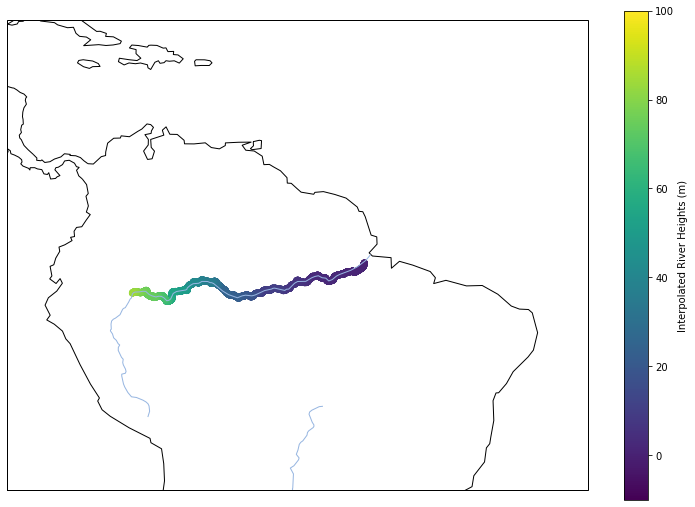

In [63]:
fig = plt.figure(figsize=[13,9]) 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-85, -30, -20, 20])
ax.add_feature(cartopy.feature.RIVERS)

plt.scatter(ds_MEaSUREs.lon, ds_MEaSUREs.lat, lw=1, c=ds_MEaSUREs.height[:,9069])
plt.colorbar(label='Interpolated River Heights (m)')
plt.clim(-10,100)

plt.show()

For GRACE-FO, plotting lwe_thickness[107:179,34,69] indicates time, latitude, and longitude indices corresponding to the pixel for the time period 1/2019 to 12/2019 at lat/lon (-0.7, -50). For the 2019 year, measurements of LWE thickness followd expected patterns of high volume of water from the river output into the estuary.

**2011-2019 Seasonality Plots (WIP)**

For GRACE-FO, plotting lwe_thickness[107:179,34,69] indicates time, latitude, and longitude indices corresponding to the pixel for the time period 8/2011 to 12/2019 at lat/lon (-0.7, -50).

NameError: name 'subset_GRACE' is not defined

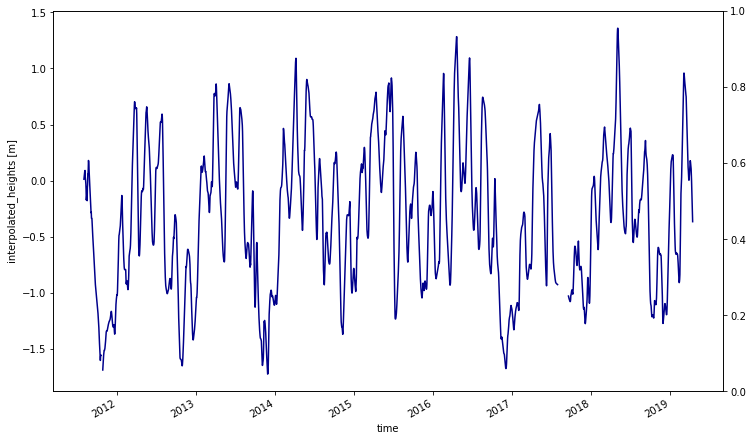

In [64]:
#plot variables associated with river
fig, ax1 = plt.subplots(figsize=[12,7])
#plot river height
ds_MEaSUREs.height[16,6689:9469].plot(color='darkblue')

#plot LWE thickness on secondary axis
ax2 = ax1.twinx()
ax2.plot(subset_GRACE.time[107:179], subset_GRACE.lwe_thickness[107:179,34,69], color = 'darkorange')

ax1.set_xlabel('Date')
ax2.set_ylabel('Land Water Equivalent Thickness (cm)', color='darkorange')
ax1.set_ylabel('River Height (m)', color='darkblue')
ax2.legend(['GRACE-FO'], loc='upper right')
ax1.legend(['Pre-SWOT MEaSUREs'], loc='lower right')

plt.title('Amazon Estuary, 2011-2019 Lat, Lon = (-0.7, -50)')

plt.show()

____

## __Set up for in-region access__


__This notebook must be running within an AWS EC2 instance running in the `us-west-2` region.__

For the live AGU Workshop, our BinderHub instance already takes care of steps 1 and 2, but these instructions are provided so that you can set this up in your own AWS account outside of the workshop.

1. Follow tutorials 01 through 03 of the [NASA Earthdata Cloud Primer](https://earthdata.nasa.gov/learn/user-resources/webinars-and-tutorials/cloud-primer) to set up an EC2 instance within us-west-2. Ensure you are also following step 3 in the ["Jupyter Notebooks on AWS EC2 in 12 (mostly easy) steps"](https://medium.com/@alexjsanchez/python-3-notebooks-on-aws-ec2-in-15-mostly-easy-steps-2ec5e662c6c6) article to set the correct security group settings needed to connect your local port to your EC2’s notebook port thru SSH.

2. Follow the remaining instructions in the Medium article above up until Step 11 (running Jupyter Lab). These instructions include installation of Anaconda3 (including Jupyter Lab) in your ec2 instance. Note the following updates and suggestions:
    * Step 5: Type the following command instead of what is suggested in the article: `ssh -i "tutorialexample.pem" ec2-user@ec2-54-144-47-199.compute-1.amazonaws.com -L 9999:localhost:8888`. This will eliminate the need to create a ssh config file in your home directory (Step 10).
    * As of December 2020, the most current Anaconda3 Linux distribution is: https://repo.anaconda.com/archive/Anaconda3-2020.11-Linux-x86_64.sh
    * The Anaconda installation prompts are not the same as in the article. You will not be prompted to include Anaconda3 in your .bashrc PATH so you can skip to their step 9. Instead select "yes" to initialize Anaconda by running `conda init`. 

Before moving over to Jupyter Lab, set up your Earthdata Login authentication and Harmony access keys:

3. Setup your `~/.netrc` for Earthdata Login in your ec2 instance:

```
cd ~
touch .netrc
echo "machine urs.earthdata.nasa.gov login uid_goes_here password password_goes_here" > .netrc
chmod 0600 .netrc
```

4. Run the following in your ec2 instance terminal window to generate short-term Harmony access keys:

`curl -Ln -bj https://harmony.earthdata.nasa.gov/cloud-access.sh`

5. Set your environment variables based on the keys provided in step 4:

`export AWS_ACCESS_KEY_ID='...
export AWS_SECRET_ACCESS_KEY='...'
export AWS_SESSION_TOKEN='...'
export AWS_DEFAULT_REGION='us-west-2'`

Note that these expire within 8 hours of the script generation.

6. Launch jupyter lab:

`jupyter lab --no-browser`

Copy the URL that begins with `http://localhost:8888` into a browser window. Replace `8888` with `9999`. 

You should now be up and running with JupyterLab in your EC2!
****

*****
### OLD MATERIAL FROM EARLIER DRAFT

#### __On your own activity since this mimics same SMAP workflow?? Maybe have them explore using CMR or EDSC to find concurrent data first using previous tutorials...__

Spatial subsetting

In [ ]:
modis_collection_id='C1940475563-POCLOUD'
harmony_root = 'https://harmony.earthdata.nasa.gov'
params = {
    'collection_id': modis_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'lat':'(-1.31873:2.96977)',
    'lon':'(-53.00754:-46.39751)',
    'start': '2020-11-15T00:00:00.000Z',
    'stop':'2020-11-15T23:59:59.000Z'
}

modis_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&subset=lat{lat}&subset=lon{lon}&subset=time("{start}":"{stop}")'.format(**params)

In [ ]:
modis_results = fn.get_harmony_results(modis_url, _token)

In [ ]:
pprint(modis_results)

Open VIA STAC...

In [ ]:
job = modis_results['jobID']
print(job)

stac_root = 'https://harmony.earthdata.nasa.gov/stac/{jobID}/{item}'

__Open STAC Catalog from Harmony response__

Several STAC items are listed, corresponding to each Zarr output.

In [ ]:
stac_cat = intake.open_stac_catalog(stac_root.format(jobID=job,item=''),name='Harmony output')
display(list(stac_cat))

We can inspect the metadata of each STAC item, which includes the bounding box, coordinates, and start and end time. We'll focus on the first output:

In [ ]:
item_0 = f'{job}_0'
item = stac_cat[item_0]
print(type(item))
print(item.metadata)

Each item can be accessed from the harmony s3 staging bucket:

In [ ]:
assets = list(item)
asset = item[assets[0]]
print(type(asset))
print(asset.urlpath)

### __Access Harmony outputs directly from STAC__

The Harmony output image is loaded up into an xarray data array directly from the STAC catalog.

In [ ]:
modis_da = asset.to_dask()

### __MUR SST__

Already reformatted to Zarr in AWS Open Registry

Adapted from https://github.com/pangeo-gallery/osm2020tutorial

In [ ]:
# $ conda install -c conda-forge zarr
!{sys.executable} -m pip install zarr
!{sys.executable} -m pip install aiohttp

import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import requests

In [ ]:
ds_sst = xr.open_zarr('https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1',consolidated=True)

ds_sst

#### Explore data

In [ ]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction))
sst_masked = ds_sst['analysed_sst'].where(cond)

### Memory issue...

In [ ]:
%%time
sst_day = sst_masked.sel(time='2015-10-01',lat=slice(20,65),lon=slice(-170,-110)).load()

In [ ]:
# sst_day.plot()
sst_masked.plot()